# **BLACK-SCHOLES MODEL**
[Black-Scholes model basics](https://www.investopedia.com/terms/b/blackscholes.asp)

**IMPORTING THE LIBRARIES**

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import date

import warnings
warnings.filterwarnings("ignore")

# to fetch data
import yfinance as yf

import scipy.stats as ss
from scipy.stats import norm


**IMPORTING DATA**

In [92]:
symbol = '^SPX'
end = date.today()
start = end.replace(year = 2022)

tickerData = yf.Ticker(symbol)

# Read data
df = tickerData.history(period='1d', start=start, end=end, interval = '1d')


df.tail()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-12-28 00:00:00-05:00,4786.439941,4793.299805,4780.979980,4783.350098,2698860000,0.0,0.0
2023-12-29 00:00:00-05:00,4782.879883,4788.430176,4751.990234,4769.830078,3126060000,0.0,0.0
2024-01-02 00:00:00-05:00,4745.200195,4754.330078,4722.669922,4742.830078,3743050000,0.0,0.0
2024-01-03 00:00:00-05:00,4725.069824,4729.290039,4699.709961,4704.810059,3950760000,0.0,0.0
2024-01-04 00:00:00-05:00,4697.419922,4726.779785,4687.529785,4688.680176,3715480000,0.0,0.0


In [93]:
symbol = '^SPX'  #the ticker of the stock whose data is to be taken out
dfo = yf.Ticker(symbol)

In [94]:
dfo.options  #to get the date of different expiration time

('2024-01-05',
 '2024-01-08',
 '2024-01-09',
 '2024-01-10',
 '2024-01-11',
 '2024-01-12',
 '2024-01-16',
 '2024-01-17',
 '2024-01-18',
 '2024-01-19',
 '2024-01-22',
 '2024-01-23',
 '2024-01-24',
 '2024-01-25',
 '2024-01-26',
 '2024-01-29',
 '2024-01-30',
 '2024-01-31',
 '2024-02-01',
 '2024-02-02',
 '2024-02-05',
 '2024-02-06',
 '2024-02-07',
 '2024-02-09',
 '2024-02-12',
 '2024-02-16',
 '2024-02-29',
 '2024-03-15',
 '2024-03-28',
 '2024-04-19',
 '2024-04-30',
 '2024-05-17',
 '2024-05-31',
 '2024-06-21',
 '2024-06-28',
 '2024-07-19',
 '2024-08-16',
 '2024-09-20',
 '2024-09-30',
 '2024-10-18',
 '2024-11-15',
 '2024-12-20',
 '2024-12-31',
 '2025-01-17',
 '2025-03-21',
 '2025-06-20',
 '2025-12-19',
 '2026-03-20',
 '2026-12-18',
 '2027-12-17',
 '2028-12-15',
 '2029-12-21')

In [95]:
dfo_exp = dfo.option_chain(dfo.options[1])  #you can change index to try on different expiry dates

In [96]:
dfo_exp.calls.head() #data for call options

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPXW240108C01200000,2023-12-18 15:43:40+00:00,1200.0,3537.84,3474.2,3480.4,0.0,0.0,NaN,1,0.000010,True,REGULAR,USD
1,SPXW240108C01400000,2023-12-01 15:14:07+00:00,1400.0,3170.20,3363.8,3375.9,0.0,0.0,1.0,1,8.387761,True,REGULAR,USD
2,SPXW240108C02200000,2023-12-29 15:44:44+00:00,2200.0,2581.30,2474.4,2480.6,0.0,0.0,2.0,2,0.000010,True,REGULAR,USD
3,SPXW240108C03200000,2023-12-18 15:43:40+00:00,3200.0,1544.96,1474.7,1480.7,0.0,0.0,NaN,1,0.000010,True,REGULAR,USD
4,SPXW240108C03800000,2023-12-19 20:35:31+00:00,3800.0,973.14,874.7,880.8,0.0,0.0,1.0,2,0.000010,True,REGULAR,USD


# **CALCULATION OF ANNUAL VOLATALITY**
Annual volatility of the stock can be calculated as:

Calculating daily logarithmic returns

Then calculating its standard deviation to get daily volatility

Then multiplying it by sqrt(252) as there are 252 trading days in a year.

In [97]:
def annual_vol(df):
    """
    Function to calculate annual volatility

    Parameters
    ----------
    df : dataframe
         Stock info

    Returns
    -------
    vol : float
        annual volatility of the stock
    """
    ret =df['Close'].pct_change()[1:]

    log_return = np.log(ret)

    log_return = log_return[~np.isnan(log_return)]#your code here  #to remove nan
    daily_vol = log_return.std()#your code here
    vol =daily_vol*np.sqrt(252) #your code here

    return vol

In [98]:
vol = annual_vol(df)
vol

18.786473377806477

# **BLACK-SCHOLES MODEL**


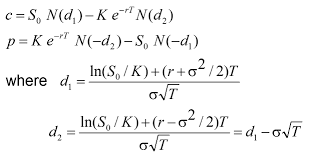

C : call option price

P : Put option price

S : Stock price

K : Strike price

r : risk free rate

t : time of maturity in year

N = Normal distribution

In [99]:
def euro_vanilla(S, K, T, r, sigma, option = 'call'):
  d1 =((np.log(S/K))+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
  d2=d1-sigma*np.sqrt(T)
  try:
    if option =='call':
      price = S*norm.cdf(d1,0,1)-K*np.exp(-r/T)*norm.cdf(d2,0,1)
    else:
      price =K*np.exp(-r*T)*norm.cdf(-d2,0,1)-S*norm.cdf(-d1,0,1)
    return price
  except:
    print(" Invalid paramethers of option")

    """
    To calculate options price with the help of black-scholes model

    Parameters
    ----------
    S : float
        The price of the underlying

    K : float
        Strike price of the option

    T : float
        Time to expiry in years

    r : float
        Risk free rate which can be taken as the US Treasury bond yield

    sigma : float
        The annual volatility of the returns

    option : string
        call for call option
        put for put option

    Returns
    -------
    premium : float
        The price of call or put option
    """


   #your code here

In [100]:
N = 100
T = 8.0/365      #Calculate the number of days left for expiry from your calculation in years
t = T/N

In [101]:
#r is the risk free rate taken from the 10 years us treasury bond
#call price calculated from black scholes model
call = {}
for K in dfo_exp.calls['strike']:
    call_price = euro_vanilla(S = df['Close'][len(df)-1], K = K, T = T, r=0.0123*t, sigma=vol)
  # print(call_price)
    call[K] = call_price
th_call = pd.DataFrame.from_dict(call, orient='index')
th_call.rename(columns = {0:"th_call"}, inplace = True)
th_call.head()

,th_call
1200.0,4327.328224
1400.0,4292.038279
2200.0,4173.131909
3200.0,4055.963670
3800.0,3996.314467


In [102]:
#actual call price
ac_call = dfo_exp.calls.loc[:, ['strike', 'lastPrice']]
ac_call.set_index('strike', inplace = True)
ac_call.rename(columns = {"lastPrice":"ac_call"}, inplace=True)
ac_call.head()

,ac_call
strike,
1200.0,3537.84
1400.0,3170.20
2200.0,2581.30
3200.0,1544.96
3800.0,973.14


In [103]:
call = th_call
call["ac_call"] = ac_call
call.head(10)

,th_call,ac_call
1200.0,4327.328224,3537.84
1400.0,4292.038279,3170.20
2200.0,4173.131909,2581.30
3200.0,4055.963670,1544.96
3800.0,3996.314467,973.14
4000.0,3977.776911,749.57
4050.0,3973.236393,603.77
4150.0,3964.263229,577.62
4200.0,3959.829299,580.00
4250.0,3955.429643,462.83


<Axes: >

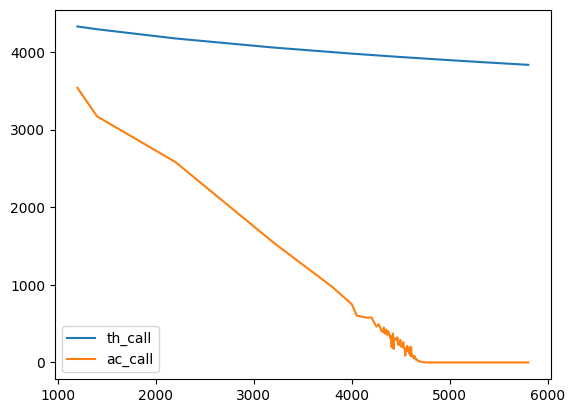

In [104]:
call.plot() #plotting the actual and theoretical call prices

In [105]:
#r is the risk free rate taken from the 10 years us treasury bond
#theoretical put price calculated from black scholes model
put = {}
for K in dfo_exp.puts['strike']:
    put_price = euro_vanilla(S = df['Close'][len(df)-1], K = K, T = T, r=0.0158*t, sigma=vol, option = 'put')
  # print(put_price)
    put[K] = put_price
th_put = pd.DataFrame.from_dict(put, orient='index')
th_put.rename(columns = {0:"th_put"}, inplace = True)
th_put.head()

,th_put
2000.0,1511.477196
2200.0,1684.415963
2400.0,1858.752966
2600.0,2034.326591
2800.0,2211.003811


In [106]:
#actual put price
ac_put = dfo_exp.puts.loc[:, ['strike', 'lastPrice']]
ac_put.set_index('strike', inplace = True)
ac_put.rename(columns = {"lastPrice":"ac_put"}, inplace=True)
ac_put.head()

,ac_put
strike,
2000.0,0.05
2200.0,0.05
2400.0,0.07
2600.0,0.05
2800.0,0.07


In [107]:
put = th_put
put["ac_put"] = ac_put
put.tail(10)

,th_put,ac_put
4850.0,4066.376659,127.03
4855.0,4070.975105,78.75
4860.0,4075.573827,130.02
4870.0,4084.772098,145.98
4900.0,4112.373490,117.50
4920.0,4130.779868,192.35
4930.0,4139.984681,147.22
4950.0,4158.397541,175.95
5000.0,4204.448396,283.41
5100.0,4296.628920,365.37


<Axes: >

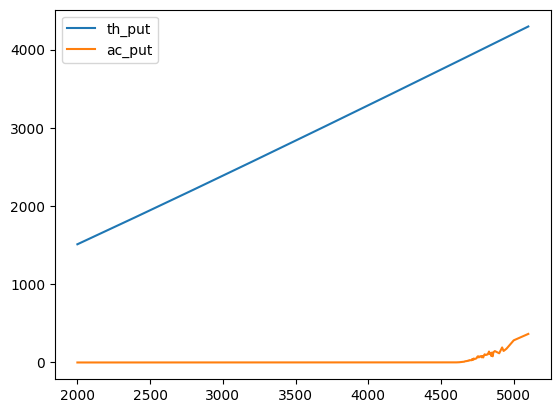

In [108]:
put.plot()